# Import libraries

In [267]:
import os
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import PIL.Image
import numpy as np

In [268]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Dataset preprocessing

In [269]:
dataset_path = '../dataset/helmet_classify_img'
os.listdir(dataset_path)

['helmet', 'no_helmet']

In [270]:
ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(256, 256),
    color_mode='rgb',
    batch_size=10,
    shuffle=True,
)

Found 351 files belonging to 2 classes.


In [271]:
ds_iter = ds.as_numpy_iterator()
batch = ds_iter.next()
batch[1] # 10 images of 256x256x3

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0])

## Visualize images and classes

In [272]:
batch = ds_iter.next()

In [273]:
class_names = ds.class_names
class_names

['helmet', 'no_helmet']

In [274]:
def visualize_batch(batch):
    fig, ax = plt.subplots(ncols=5, figsize=(20, 20))
    for idx, im in enumerate(batch[0][:5]):
        ax[idx].imshow(im)
        ax[idx].title.set_text(batch[1][idx])

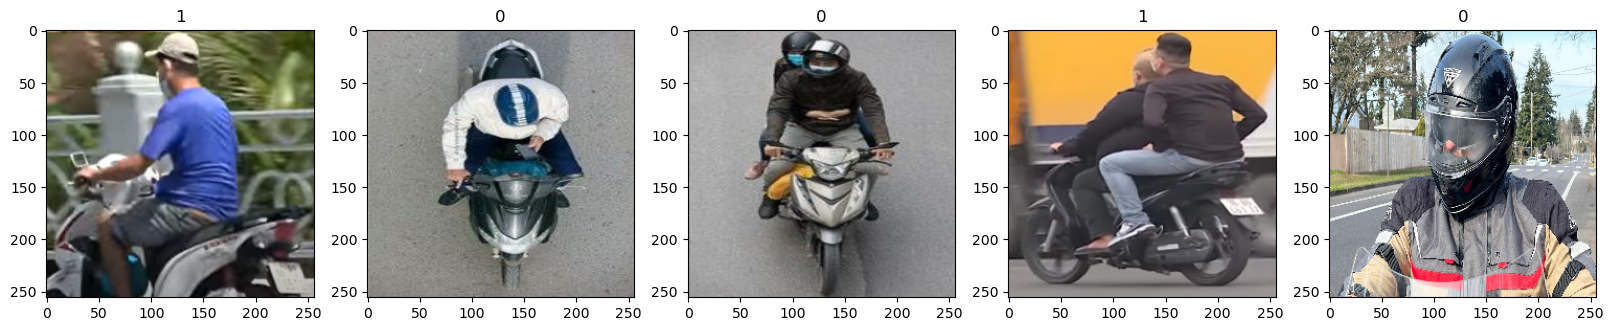

In [275]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 20))
for idx, im in enumerate(batch[0][:5]):
    ax[idx].imshow(im.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Scaling images

In [276]:
batch[0].max()

255.0

In [277]:
ds = ds.map(lambda x,y: (x/255,y))

In [278]:
scaled_batch_iter = ds.as_numpy_iterator()

In [279]:
scaled_batch = scaled_batch_iter.next()
scaled_batch[0].max()

1.0

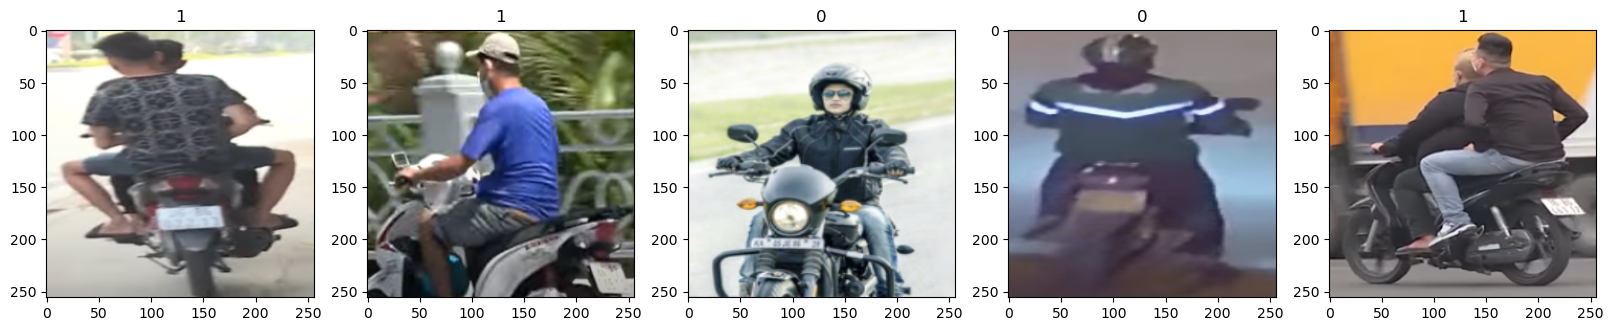

In [280]:
visualize_batch(scaled_batch)

## Augmentation for  more data

In [281]:
from tensorflow.image import stateless_random_contrast, stateless_random_brightness, stateless_random_saturation, stateless_random_flip_left_right
from tensorflow.random import Generator

In [282]:
def show_diff(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

In [283]:
rng = Generator.from_seed(123, alg='philox')
def augment(image_label, seed):
    image, label = image_label
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    
    image = stateless_random_brightness(image, max_delta=0.2, seed=new_seed)
    image = stateless_random_contrast(image, 0.5, 2.0, seed=new_seed)
    image = stateless_random_flip_left_right(image, seed=new_seed)
    image = stateless_random_saturation(image, 0.75, 1.25, seed=new_seed)
    return image, label

def make_seed_and_augment(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

### Visualizing random augmentation effect

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


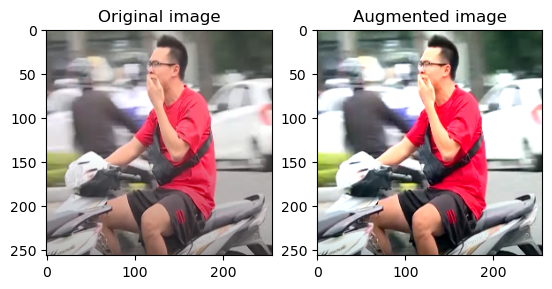

In [284]:
first_img = scaled_batch_iter.next()
augment_img = make_seed_and_augment(first_img[0][0], first_img[1][0])[0]
show_diff(first_img[0][0], augment_img)

## Splitting train-val-test

In [285]:
len(ds)

36

In [286]:
train_size = int(len(ds) * .7)
val_size = int(len(ds) * .2) + 1
test_size = int(len(ds) * .1)

In [287]:
train_size + val_size + test_size

36

In [288]:
train_set = ds.take(train_size)
val_set = ds.skip(train_size).take(val_size)
test_set = ds.skip(train_size + val_size).take(test_size)

### Apply on train set

In [289]:
aug_train = train_set.map(make_seed_and_augment)

In [290]:
aug_iter = aug_train.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


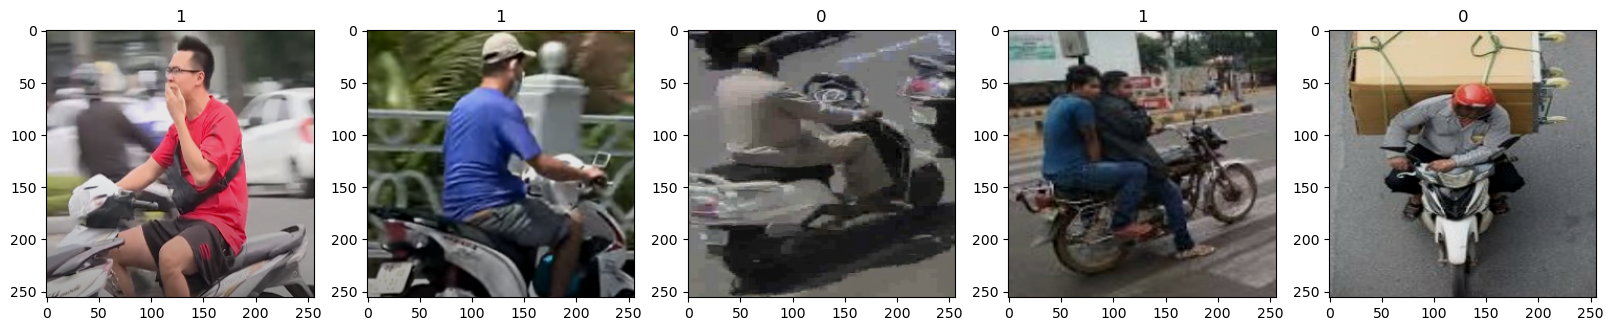

In [291]:
aug_train_batch = aug_iter.next()
visualize_batch(aug_train_batch)

In [294]:
train_set = tf.data.Dataset.sample_from_datasets([train_set, aug_train], weights=[0.5, 0.5])

In [296]:
train_set_iter = train_set.as_numpy_iterator()

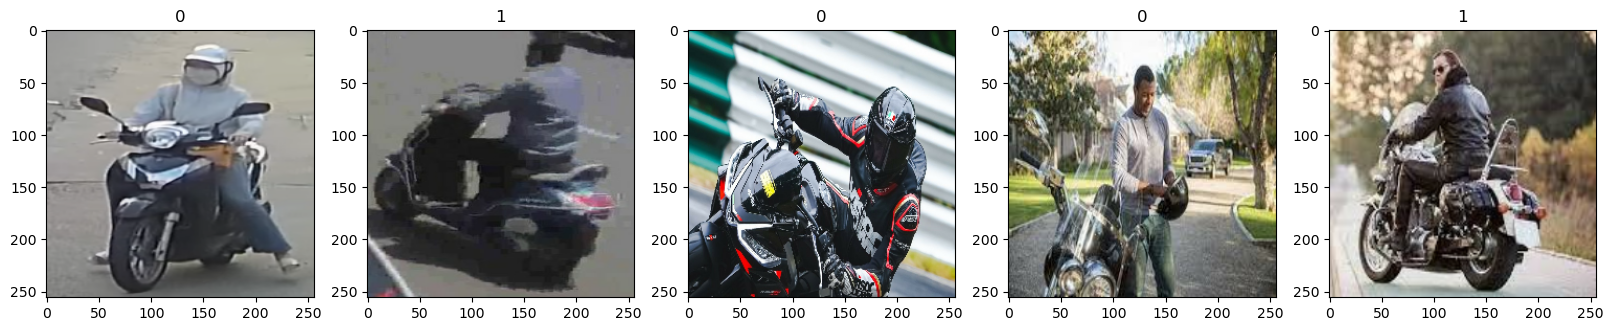

In [300]:
batch = train_set_iter.next()
visualize_batch(batch)

In [78]:
val_iter = val_set.as_numpy_iterator()

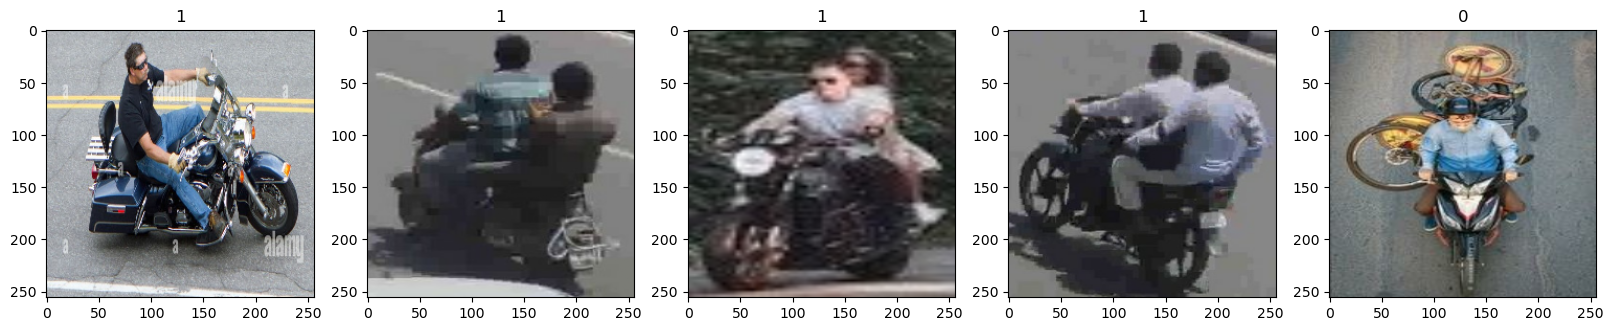

In [301]:
val_batch = val_iter.next()
visualize_batch(val_batch)

In [302]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)

# Model (CNN)

In [303]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers

In [604]:
model = Sequential()

In [605]:
model.add(Conv2D(8, (3,3), 1, activation="relu", kernel_initializer='he_normal', input_shape=(256,256,3)))
model.add(MaxPooling2D(3,3))

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D(3,3))

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D(3,3))


model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))


In [606]:
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4, decay=0.15)

In [607]:
model.compile(optimizer=optimizer, loss=tf.losses.BinaryCrossentropy(), metrics="accuracy")

In [608]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_94 (MaxPoolin  (None, 84, 84, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 82, 82, 16)        1168      
                                                                 
 max_pooling2d_95 (MaxPoolin  (None, 27, 27, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 8, 8, 32)       

In [609]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-8
)

In [623]:
history = model.fit(train_set, epochs=200, validation_data=val_set, callbacks=[lr_callback])

Epoch 1/200


50/50 [==============================] - 1s 14ms/step - loss: 0.6021 - accuracy: 0.7140 - val_loss: 0.6176 - val_accuracy: 0.7500 - lr: 8.0000e-04
Epoch 2/200
50/50 [==============================] - 1s 12ms/step - loss: 0.6017 - accuracy: 0.7100 - val_loss: 0.6168 - val_accuracy: 0.7500 - lr: 8.0000e-04
Epoch 3/200
50/50 [==============================] - 1s 12ms/step - loss: 0.6080 - accuracy: 0.6940 - val_loss: 0.6159 - val_accuracy: 0.7500 - lr: 8.0000e-04
Epoch 4/200
50/50 [==============================] - 1s 12ms/step - loss: 0.5960 - accuracy: 0.7100 - val_loss: 0.6156 - val_accuracy: 0.7500 - lr: 8.0000e-04
Epoch 5/200
50/50 [==============================] - 1s 12ms/step - loss: 0.6040 - accuracy: 0.7540 - val_loss: 0.6150 - val_accuracy: 0.7500 - lr: 8.0000e-04
Epoch 6/200
50/50 [==============================] - 1s 12ms/step - loss: 0.5909 - accuracy: 0.7260 - val_loss: 0.6145 - val_accuracy: 0.7500 - lr: 8.0000e-04
Epoch 7/200
50/50 [==============================] - 1s 12

## Training monitoring

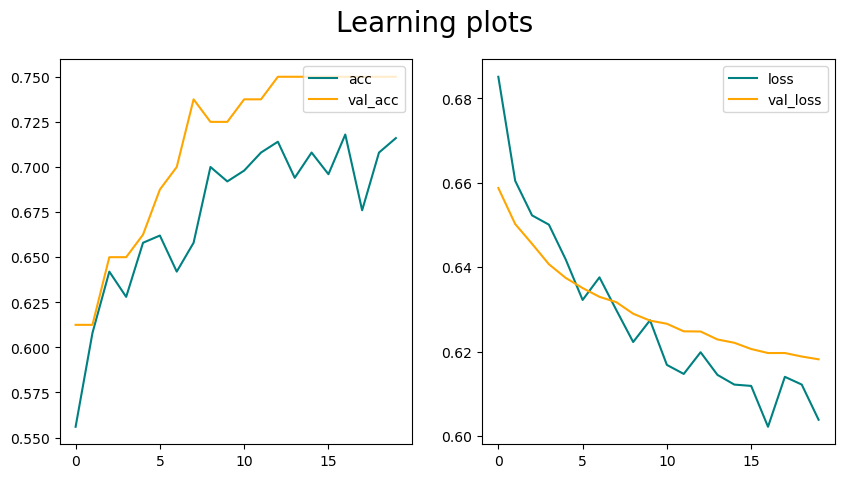

In [611]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='teal', label='acc')
plt.plot(history.history['val_accuracy'], color='orange', label='val_acc')

plt.legend(loc="upper right")

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')

fig.suptitle('Learning plots', fontsize=20)
plt.legend(loc="upper right")
plt.show()


## Evaluating

In [612]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [613]:
precision_score = Precision()
recall_score = Recall()
acc = BinaryAccuracy()

In [614]:
len(test_set)

3

In [615]:
for batch in test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision_score.update_state(y, yhat)
    recall_score.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 20ms/step


In [616]:
print(f"Precision: {precision_score.result().numpy()}, Recall: {recall_score.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision: 0.25, Recall: 0.1666666716337204, Accuracy: 0.6190476417541504


In [617]:
sample = test_set.as_numpy_iterator()

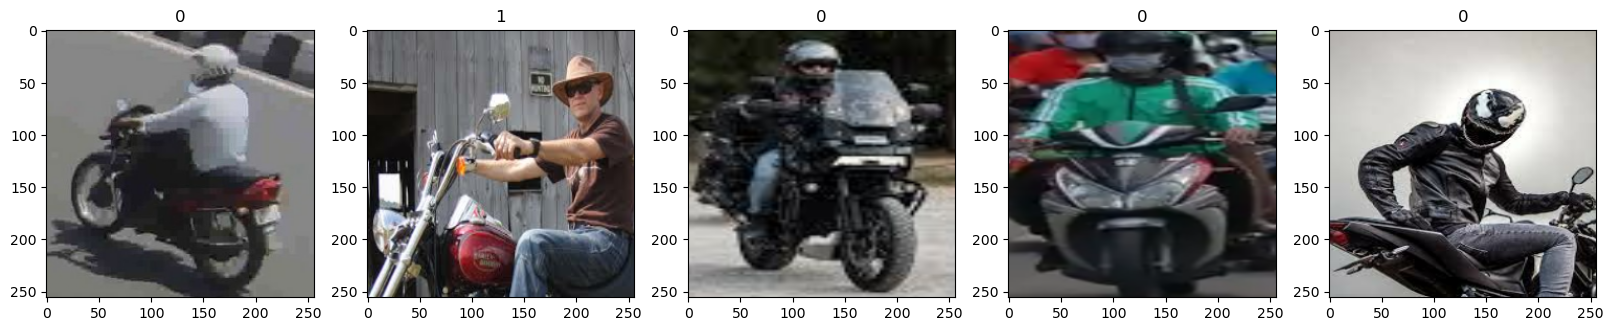

In [618]:
sample = sample.next()
visualize_batch(sample)

In [619]:
x = sample[0]
y = sample[1]
yhat = np.squeeze((model.predict(x) > 0.5).astype("int32"))
print(y, yhat)

1/1 [==============================] - 0s 25ms/step
[0 1 0 0 0 1 0 0 1 1] [1 1 0 0 1 1 0 0 0 0]


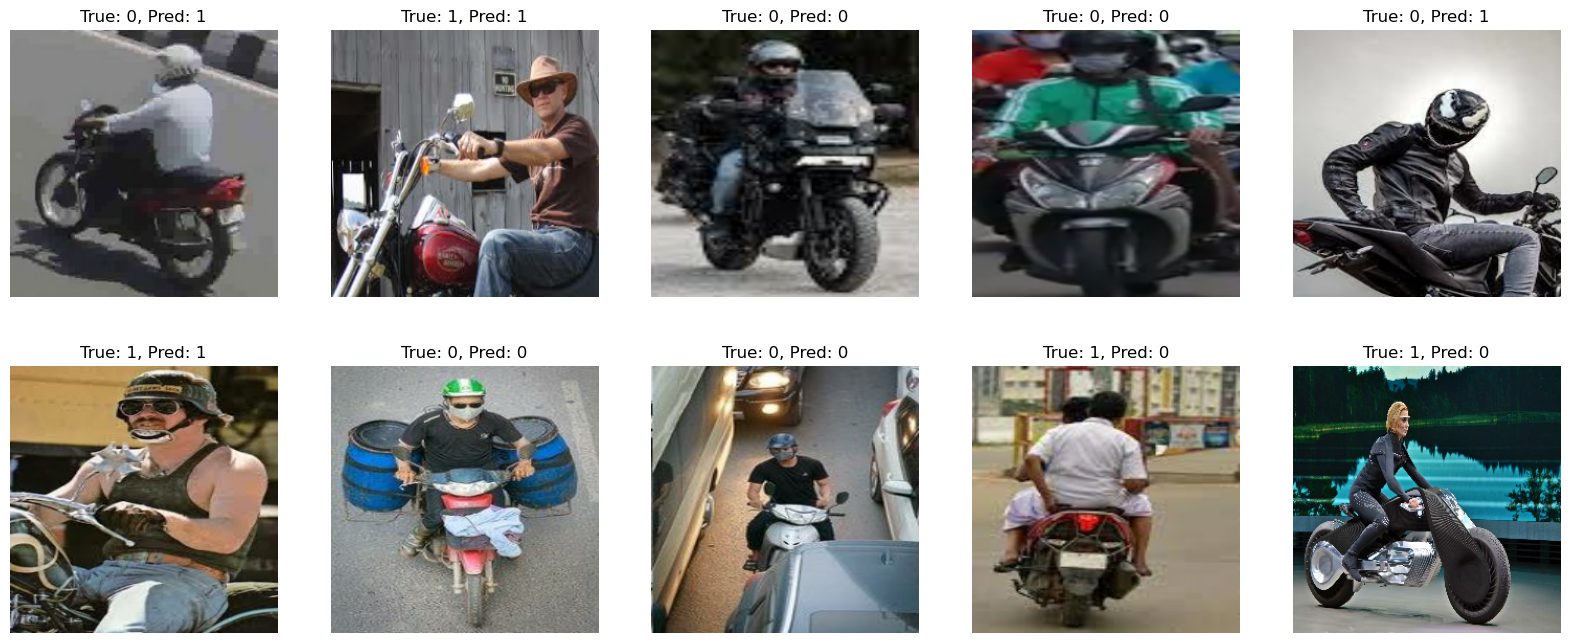

In [620]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8))
for idx, ax in enumerate(axes.flatten()[:10]):
    ax.imshow(x[idx])
    ax.title.set_text(f"True: {y[idx]}, Pred: {yhat[idx]}")
    ax.axis('off')


## Save model at /checkpoints

In [621]:
# from tensorflow.keras.models import load_model, save_model

In [622]:
# model.save(os.path.join('../checkpoints', '14_1/helmet.h5'))